In [1]:
!pip install pandas
!pip install matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

# **1. Робота з архівами даних у Pandas**

## Легенда

Уявімо типовий кейс e-commerce.  

Нам передали архів:

```
ecommerce_events_all.zip
 ├─ 2019-Oct.csv
 ├─ 2019-Nov.csv
 ├─ 2019-Dec.csv
 ├─ 2020-Jan.csv
 └─ 2020-Feb.csv
```

Кожен файл — події користувачів за окремий місяць.  
Дані беремо тут: https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop  

Датасет містить поведінкові дані інтернет-магазину косметики за період **жовтень 2019 — лютий 2020**.
Дані надані проєктом **Open CDP**.

**Кожен CSV-файл відповідає одному календарному місяцю спостережень.**

Один файл є **журналом подій користувачів за місяць**.

Файл містить **сирі події**, які фіксують взаємодію користувачів з товарами в інтернет-магазині.

**Кожен рядок — це одна подія.**

---

| Поле            | Тип даних  | Опис                                       | Додаткові примітки                                               |
| --------------- | ---------- | ------------------------------------------ | ---------------------------------------------------------------- |
| `event_time`    | `datetime` | Час, коли відбулася подія                  | Часова зона: **UTC**                                             |
| `event_type`    | `string`   | Тип події користувача                      | Можливі значення: `view`, `cart`, `remove_from_cart`, `purchase` |
| `product_id`    | `int`      | Унікальний ідентифікатор товару            | Один товар може мати багато подій                                |
| `category_id`   | `int`      | Ідентифікатор категорії товару             | Повторюється для різних товарів                                  |
| `category_code` | `string`   | Ієрархічний код категорії товару           | Може бути відсутнім (`NaN`), напр. `electronics.smartphone`      |
| `brand`         | `string`   | Назва бренду товару (lowercase)            | Може бути відсутньою (`NaN`)                                     |
| `price`         | `float`    | Ціна товару на момент події                | Присутня завжди                                                  |
| `user_id`       | `int`      | Постійний ідентифікатор користувача        | Один користувач має багато подій                                 |
| `user_session`  | `string`   | Тимчасовий ідентифікатор сесії користувача | Одна сесія — багато подій; змінюється після довгої паузи         |

---

Поведінкові особливості даних:
* Дані мають **подієву структуру (event-based)**
* Відношення між користувачами і товарами — **many-to-many**
* Один користувач може:
  * мати багато сесій
  * мати багато подій у межах однієї сесії
* Одна сесія може містити кілька подій `purchase`
  (це одна покупка, що складається з кількох товарів)
* Подія `purchase` **не є замовленням** у класичному розумінні. Замовлення потрібно визначати аналітично (наприклад, через агрегацію `purchase` по `user_session`)

## Наївний підхід щодо завантаження даних з архіву (не працює)

```python
pd.read_csv("ecommerce_events.zip")
```

Так можна робити **лише якщо в архіві один CSV**.  
Як тільки файлів більше — Pandas не розуміє, який саме читати.  
**У реальних проєктах цей спосіб майже ніколи не підходить.**

In [3]:
df = pd.read_csv("ecommerce_events_2019_Dec.zip")
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [4]:
df = pd.read_csv("ecommerce_events_all.zip")
df.head()

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['2019-Dec.csv', '2020-Jan.csv', '2020-Feb.csv', '2019-Oct.csv', '2019-Nov.csv']

## Читання файлів прямо з архіву

1. Відкрити ZIP-архів
2. Перебрати всі CSV
3. Прочитати кожен файл
4. Об’єднати в один DataFrame

### Читаємо окремий файл з архіву

In [5]:
import zipfile

In [6]:
zip_name = 'ecommerce_events_all.zip'
csv_files = ['2019-Dec.csv', '2020-Jan.csv', '2020-Feb.csv', '2019-Oct.csv', '2019-Nov.csv']

dfs = []

with zipfile.ZipFile(zip_name) as archive:
    for item in csv_files:
        file = archive.open(item)
        df = pd.read_csv(file)
        dfs.append(df)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


### Читаємо всі csv-файли з архіву

### Додатковий стовпчик `source_file`

В кожний датасет, який завантажуємо, додаємо стовпчик `source_file`, який дозволяє:

* перевірити, чи всі файли підвантажились
* знайти помилки в конкретному місяці
* зрозуміти, звідки з’явилась аномалія в даних
* швидко відкотитись, якщо один файл виявився «битим»

У реальних проєктах **без цього дебаг перетворюється на гадання**.

Аналітик **ніколи не переходить до аналізу**, доки не переконається, що:

* кількість рядків очікувана
* всі файли враховані
* немає «порожніх» або дивних частин


In [7]:
zip_name = 'ecommerce_events_all.zip'
dfs = []

with zipfile.ZipFile(zip_name) as archive:
    for item in archive.namelist():
        if item.endswith('.csv'):
            file = archive.open(item)
            df = pd.read_csv(file)
            df['source_file'] = item
            dfs.append(df)

In [8]:
len(dfs)

5

In [9]:
df = pd.concat(dfs, ignore_index=True)

In [10]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,source_file
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019-Dec.csv
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019-Dec.csv
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019-Dec.csv
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019-Dec.csv
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-Dec.csv


In [11]:
df.shape

(20692840, 10)

In [12]:
df.source_file.unique()

array(['2019-Dec.csv', '2020-Jan.csv', '2020-Feb.csv', '2019-Oct.csv',
       '2019-Nov.csv'], dtype=object)

## Робота з типами даних

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
 9   source_file    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 1.5+ GB


In [ ]:
df['event_time'] = pd.to_datetime(df.event_time)

In [14]:
df['event_time'].head(5)

0    2019-12-01 00:00:00 UTC
1    2019-12-01 00:00:00 UTC
2    2019-12-01 00:00:02 UTC
3    2019-12-01 00:00:05 UTC
4    2019-12-01 00:00:07 UTC
Name: event_time, dtype: object

In [15]:
df['event_time'] = pd.to_datetime(df.event_time, format='%Y-%m-%d %H:%M:%S UTC', errors='coerce', utc=True)

## Оптимізація памʼяті

Після обʼєднання файлів ми отримали **один великий DataFrame**.
Перше, що потрібно зробити — **дивитися не на графіки, а на памʼять**.

In [16]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 10 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  object             
 5   brand          object             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
 9   source_file    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(5)
memory usage: 6.2 GB


Типова картина:

* багато `object`
* повторювані строкові значення
* зайве споживання памʼяті

> Якщо дані не влазять у памʼять — ніякий аналіз далі не має значення.

### int64 -> int32

### str -> category

In [38]:
# допоміжні колонки
df["date"] = df["event_time"].dt.date
df["month"] = df["event_time"].dt.to_period("M")

C:\Users\olehs\AppData\Local\Temp\ipykernel_5824\3530858144.py:3: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



## Скільки унікальних користувачів активно користуються продуктом за місяць?

In [39]:
mau = (
    df.groupby("month")["user_id"]
      .nunique()
      .reset_index(name="MAU")
)

mau


,month,MAU
0,2019-10,399664
1,2019-11,368232
2,2019-12,370154
3,2020-01,410073
4,2020-02,391055


MAU = кількість **різних user_id**, які мали хоча б одну подію в місяці.

## Чи росте база активних користувачів?

In [40]:
# Абсолютний ріст MAU
mau["MAU_growth"] = mau["MAU"].diff()
mau

,month,MAU,MAU_growth
0,2019-10,399664,NaN
1,2019-11,368232,-31432.0
2,2019-12,370154,1922.0
3,2020-01,410073,39919.0
4,2020-02,391055,-19018.0


In [41]:
# Відносний ріст (%)
mau["MAU_growth_pct"] = mau["MAU"].pct_change() * 100
mau

,month,MAU,MAU_growth,MAU_growth_pct
0,2019-10,399664,NaN,NaN
1,2019-11,368232,-31432.0,-7.864606
2,2019-12,370154,1922.0,0.521954
3,2020-01,410073,39919.0,10.784430
4,2020-02,391055,-19018.0,-4.637711


**Бізнес-сенс**

* `MAU_growth > 0` → база росте
* `MAU_growth < 0` → база скорочується
* % ріст потрібен для порівняння місяців різного масштабу

## Метрика MAU

* **MAU** — Month Active Users
* **MAU — «грубий» показник активності**. Показує, скільки людей принаймні раз використали продукт, але не дає інформації про **частоту використання**. Тому **MAU часто аналізують разом з DAU (Daily Active Users)** для оцінки залучення.
* MAU може коливатися щомісяця через свята, маркетингові кампанії, оновлення продукту. Тому зручно дивитися **тренд MAU за кілька місяців**.

**Бізнес-задача:**

* Ми хочемо збільшити активну базу користувачів на 20% протягом кварталу.

**Пошук рішення через MAU:**

1. Визначити поточний MAU за останні 3 місяці.
2. Виявити сегменти користувачів з низькою частотою активності.
3. Запустити кампанії для повернення цих користувачів або залучення нових.
4. Порівняти **MAU після кампаній** з базовим рівнем — зрозуміти ефективність.

У нас є продукт, яким користуються тисячі людей. Частина з них заходить майже щодня, частина — раз на місяць, а частина — лише один раз. Потрібно зрозуміти:
**Це продукт, до якого люди повертаються регулярно, чи це продукт “зайшов раз — і забув”?**

Іншими словами, нас цікавить не просто кількість користувачів, а **наскільки часто вони реально користуються продуктом**.

Щоб відповісти на це питання, нам потрібно:

1. Порахувати, **скільки різних користувачів було активних за місяць**
   → це MAU.
2. Порахувати, **скільки різних користувачів було активних за типовий день**
   → це DAU.
3. Порівняти ці два числа між собою.

Таким чином, ми дивимось:

> **яка частка місячної аудиторії користується продуктом щодня.**


In [42]:
daily_dau = (
    df
    .groupby("date")["user_id"]
    .nunique()
)

In [43]:
daily_dau.describe()

count      152.000000
mean     18453.315789
std       3043.550818
min       7430.000000
25%      16489.500000
50%      18154.000000
75%      20099.750000
max      33859.000000
Name: user_id, dtype: float64

<Axes: >

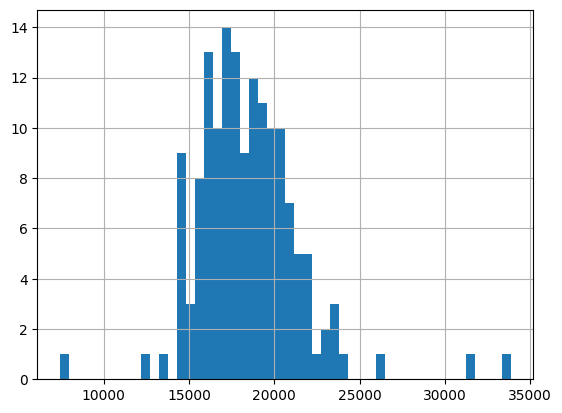

In [44]:
daily_dau.hist(bins=50)

In [45]:
avg_dau = daily_dau.median()

In [46]:
monthly_stats = (
    df
    .groupby(["month", "date"])["user_id"]
    .nunique()
    .reset_index(name="dau")
)

monthly_dau = (
    monthly_stats
    .groupby("month")["dau"]
    .median()
)

monthly_mau = (
    df
    .groupby("month")["user_id"]
    .nunique()
)

## Метрика DAU / MAU — коефіцієнт залученості

**DAU / MAU** — це частка місячних активних користувачів, які в середньому активні щодня.

**Приклад:**

* DAU = 3 000
* MAU = 30 000

DAU / MAU = 0.1 = 10%

Це означає, що **в середньому 10% усіх активних за місяць користувачів заходять у продукт щодня**.

---

## Інтерпретація значень

* **5–10%**
  Продуктом користуються нерегулярно.
  Це нормально для маркетплейсів, сервісів замовлень, e-commerce.

* **15–25%**
  Хороший рівень залученості.
  Користувачі повертаються часто, продукт має цінність.

* **30% і більше**
  Дуже висока залученість.
  Продукт стає **звичкою** (соцмережі, месенджери, стрімінг).

---

## Особливості

* **DAU / MAU — це не про ріст, а про поведінку.**
MAU може зростати, але DAU / MAU — падати. Це означає, що нові користувачі приходять, але не “втягуються”.
* **Це відносна метрика.**  
Її не можна інтерпретувати без контексту продукту та індустрії.
* **DAU / MAU ≠ Retention.**
  * Retention показує, чи користувач повернувся через N днів.
  * DAU / MAU показує, **як часто користувачі повертаються загалом**.

In [47]:
dau_mau_ratio = monthly_dau / monthly_mau
dau_mau_ratio

month
2019-10    0.042411
2019-11    0.049200
2019-12    0.047386
2020-01    0.048311
2020-02    0.050625
Freq: M, dtype: float64

## Що означають ці числа насправді

| Місяць  | DAU / MAU |
| ------- | --------- |
| 2019-10 | **4.24%** |
| 2019-11 | **4.92%** |
| 2019-12 | **4.74%** |
| 2020-01 | **4.83%** |
| 2020-02 | **5.06%** |

У середньому **лише ~4–5% місячної аудиторії** заходить у магазин **у типовий день**.

---

## Чи це погано?

### ❌ Ні. Порівняння по типах продуктів

| Тип продукту           | Типовий DAU/MAU |
| ---------------------- | --------------- |
| Соцмережі / месенджери | 30–60%          |
| Стрімінг / контент     | 15–30%          |
| **E-commerce**         | **3–10%**       |
| Travel / real estate   | 1–3%            |

**Cosmetics Shop** — класичний e-commerce →
**4–5% = абсолютно очікувано.**

---

> **Низький DAU/MAU не означає поганий продукт.
> Він означає низьку потребу в щоденному використанні.**

Косметику:

* не купують щодня
* не переглядають кожного дня
* часто повертаються **раз на кілька тижнів**

In [48]:
df["event_type"].unique()

['remove_from_cart', 'view', 'cart', 'purchase']
Categories (4, object): ['cart', 'purchase', 'remove_from_cart', 'view']

In [49]:
# Фільтруємо тільки покупки
purchases = df[df["event_type"] == "purchase"]

# Сумарний дохід на користувача
ltv = purchases.groupby("user_id")["price"].sum().mean()

print(f"Simplified LTV ≈ {ltv:.2f} у.е. на користувача")


Simplified LTV ≈ 57.44 у.е. на користувача


In [50]:
ltv_median = purchases.groupby("user_id")["price"].sum().median()
ltv_median

np.float64(33.18)

<Axes: >

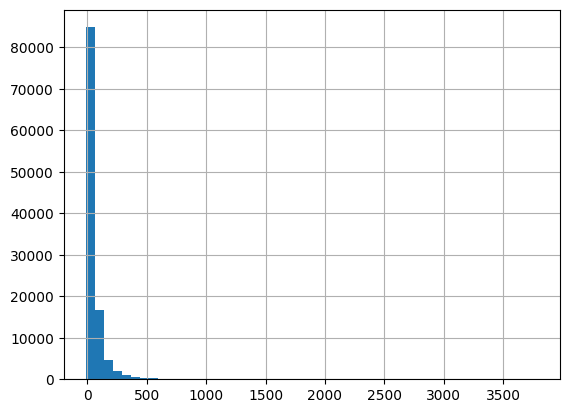

In [51]:
# Аналіз розподілу доходу користувачів

user_revenue = purchases.groupby("user_id")["price"].sum()
user_revenue.hist(bins=50)


In [52]:
# Подивитися на хвости / викиди

user_revenue.describe()

count    110518.000000
mean         57.438651
std          88.630745
min         -10.520000
25%          16.240000
50%          33.180000
75%          61.510000
max        3785.030000
Name: price, dtype: float64

In [53]:
# Очистка від викидів (опційно)

ltv_clean = user_revenue[user_revenue <= user_revenue.quantile(0.99)].mean()

In [54]:
# Аналіз після очищення

median_ltv = user_revenue.median()
print(f"Mean LTV (cleaned) = {ltv_clean:.2f}")
print(f"Median LTV = {median_ltv:.2f}")

Mean LTV (cleaned) = 51.53
Median LTV = 33.18
